In [130]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyCompare
from scipy.stats import zscore
import statsmodels.stats.weightstats as tests
from scipy import stats
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
np.set_printoptions(precision=12, suppress=False)

In [131]:
df = pd.read_csv("data.csv")
type = "activity"
property = "softActivity"
df.tail()

,bedtimeStart,Date,bedtimeEnd,Type,Provider,sleepScore,date,lightSleepDuration,sleepLatency,sleepEfficiency,...,remSleepDuration,CreatedAt,type,totalSleepDuration,averageHR,intenseActivity,caloriesBurned,steps,moderateActivity,softActivity
388,NaN,2024-03-22,NaN,activity_Withings,Withings,NaN,2024-03-22,NaN,NaN,NaN,...,NaN,1711322253,activity,NaN,NaN,0.0,426.860,6115.0,4740.0,960.0
389,NaN,2024-03-23,NaN,activity_Withings,Withings,NaN,2024-03-23,NaN,NaN,NaN,...,NaN,1711322255,activity,NaN,NaN,0.0,25.720,687.0,60.0,1080.0
390,NaN,2024-03-24,NaN,activity_Withings,Withings,NaN,2024-03-24,NaN,NaN,NaN,...,NaN,1711416912,activity,NaN,NaN,0.0,17.330,475.0,60.0,1080.0
391,NaN,2024-03-25,NaN,activity_Withings,Withings,NaN,2024-03-25,NaN,NaN,NaN,...,NaN,1711479655,activity,NaN,NaN,0.0,809.106,9690.0,8938.0,2880.0
392,NaN,2024-03-26,NaN,activity_Withings,Withings,NaN,2024-03-26,NaN,NaN,NaN,...,NaN,1711490235,activity,NaN,NaN,0.0,262.195,5173.0,2640.0,3000.0


In [132]:
categoriesSleep = ["sleepScore", "lightSleepDuration", "sleepLatency", "sleepEfficiency", "totalSleepDuration", "averageHR" ]
categoriesActivity = ["intenseActivity",
            "caloriesBurned", "steps", "moderateActivity", "softActivity"]
df_oura = df.loc[df["Type"] == f"sleep_Oura"]
df_withings = df.loc[df["Type"] == f"sleep_Withings"]
df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
# df_oura = df_oura[df_oura[property].notna()]
df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
# df_withings = df_withings[df_withings[property].notna()]
df_oura.set_index('date', inplace=True)
df_withings.set_index('date', inplace=True)
resultSleep = df_oura[categoriesSleep].sub(df_withings[categoriesSleep])
df_oura = df.loc[df["Type"] == f"activity_Oura"]
df_withings = df.loc[df["Type"] == f"activity_Withings"]
df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
# df_oura = df_oura[df_oura[property].notna()]
df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
# df_withings = df_withings[df_withings[property].notna()]
df_oura.set_index('date', inplace=True)
df_withings.set_index('date', inplace=True)
resultActivity = df_oura[categoriesActivity].sub(df_withings[categoriesActivity])
print(len(resultSleep))
print(len(resultActivity))

59
66


In [133]:
import math
Q = 0
N = 0
a_lst = []
b_lst = []
for p in categoriesSleep:
    
    df_oura = df.loc[df["Type"] == f"sleep_Oura"]
    df_withings = df.loc[df["Type"] == f"sleep_Withings"]
    df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
    df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
    df_oura.reset_index(inplace=True)
    df_withings.reset_index(inplace=True)
    zscores = zscore(resultSleep[p]).values

    for i, row in df_oura.iterrows():
        a = row[p]
        b = df_withings.loc[df_withings["date"] == row["date"]]
        b = b.iloc[0][p]
        if (min(b, a) == 0) or math.isnan(a) or math.isnan(b):
            continue
        temp = zscores[i]
        if (abs(temp) >= 2.5):
            continue
        N += 1
        val = (max(b, a) / min(b, a) % 1)
        if (a >= b):
            a_lst.append(max(b, a) / min(b, a))
            b_lst.append(1)
        else:
            a_lst.append(1)
            b_lst.append(max(b, a) / min(b, a))

        Q += val

for p in categoriesActivity:
    df_oura = df.loc[df["Type"] == f"activity_Oura"]
    df_withings = df.loc[df["Type"] == f"activity_Withings"]
    df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
    df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
    df_oura.reset_index(inplace=True)
    df_withings.reset_index(inplace=True)
    zscores = zscore(resultActivity[p]).values
    for i, row in df_oura.iterrows():
        row = row.to_dict()
        a = row[p]
        b = df_withings.loc[df_withings["date"] == row["date"]]
        b = b.iloc[0][p]
        if (min(b, a) == 0) or math.isnan(a) or math.isnan(b):
            continue
        temp = zscores[i]
        if (abs(temp) >= 2.5):
            continue
        N += 1
        val = (max(b, a) / min(b, a) % 1)
        if (a >= b):
            a_lst.append(max(b, a) / min(b, a))
            b_lst.append(1)
        else:
            a_lst.append(1)
            b_lst.append(max(b, a) / min(b, a))
        Q += val

print(Q / N)
a_lst = np.asarray(a_lst, dtype=np.float32)
b_lst = np.asarray(b_lst, dtype=np.float32)

0.267673527951078


In [134]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
from numpy.random import random

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 1.96*sd
    CI_high   = md + 1.96*sd

    plt.scatter(mean, diff, 8.5, *args, **kwargs)
    plt.axhline(md,           color='black', linestyle='-')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.xlabel("Means")
    plt.ylabel("Difference")
    plt.ylim(md - 3.2*sd, md + 3.2*sd)

    xOutPlot = np.min(mean) + (np.max(mean)-np.min(mean))*1.14

    plt.text(xOutPlot, md - 1.96*sd, 
        r'-1.96SD:' + "\n" + "%.2f" % CI_low, 
        ha = "center",
        va = "center",
        )
    plt.text(xOutPlot, md + 1.96*sd, 
        r'+1.96SD:' + "\n" + "%.2f" % CI_high, 
        ha = "center",
        va = "center",
        )
    plt.text(xOutPlot, md, 
        r'Mean diff:' + "\n" + "%.2f" % md , 
        ha = "center",
        va = "center",
        )
    plt.subplots_adjust(right=0.85)



In [135]:
df_oura = df.loc[df["Type"] == f"{type}_Oura"]
df_withings = df.loc[df["Type"] == f"{type}_Withings"]
df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
df_oura = df_oura[df_oura[property].notna()]
df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
df_withings = df_withings[df_withings[property].notna()]

[ 180. 1140. 2580.  540.  780. 2032. 1079.  960. 3480. 2460. 3180. 2700.
 1440. 2520. 2521. 1440.  780. 1681. 3120. 2160. 2640. 1800.  900. 2521.
 4800. 3301. 2280. 1500. 3421. 1080. 1980. 2461. 3600. 3780. 1800. 2040.
 1860. 3720. 3060. 2160. 5219. 1139.  840. 3301. 2401. 1440. 1980. 1200.
  120. 1320. 2040. 1800. 5520. 1310. 3226. 1079. 2160. 1980. 2340. 3240.
 2640.  960. 1080. 1080. 2880. 3000.]


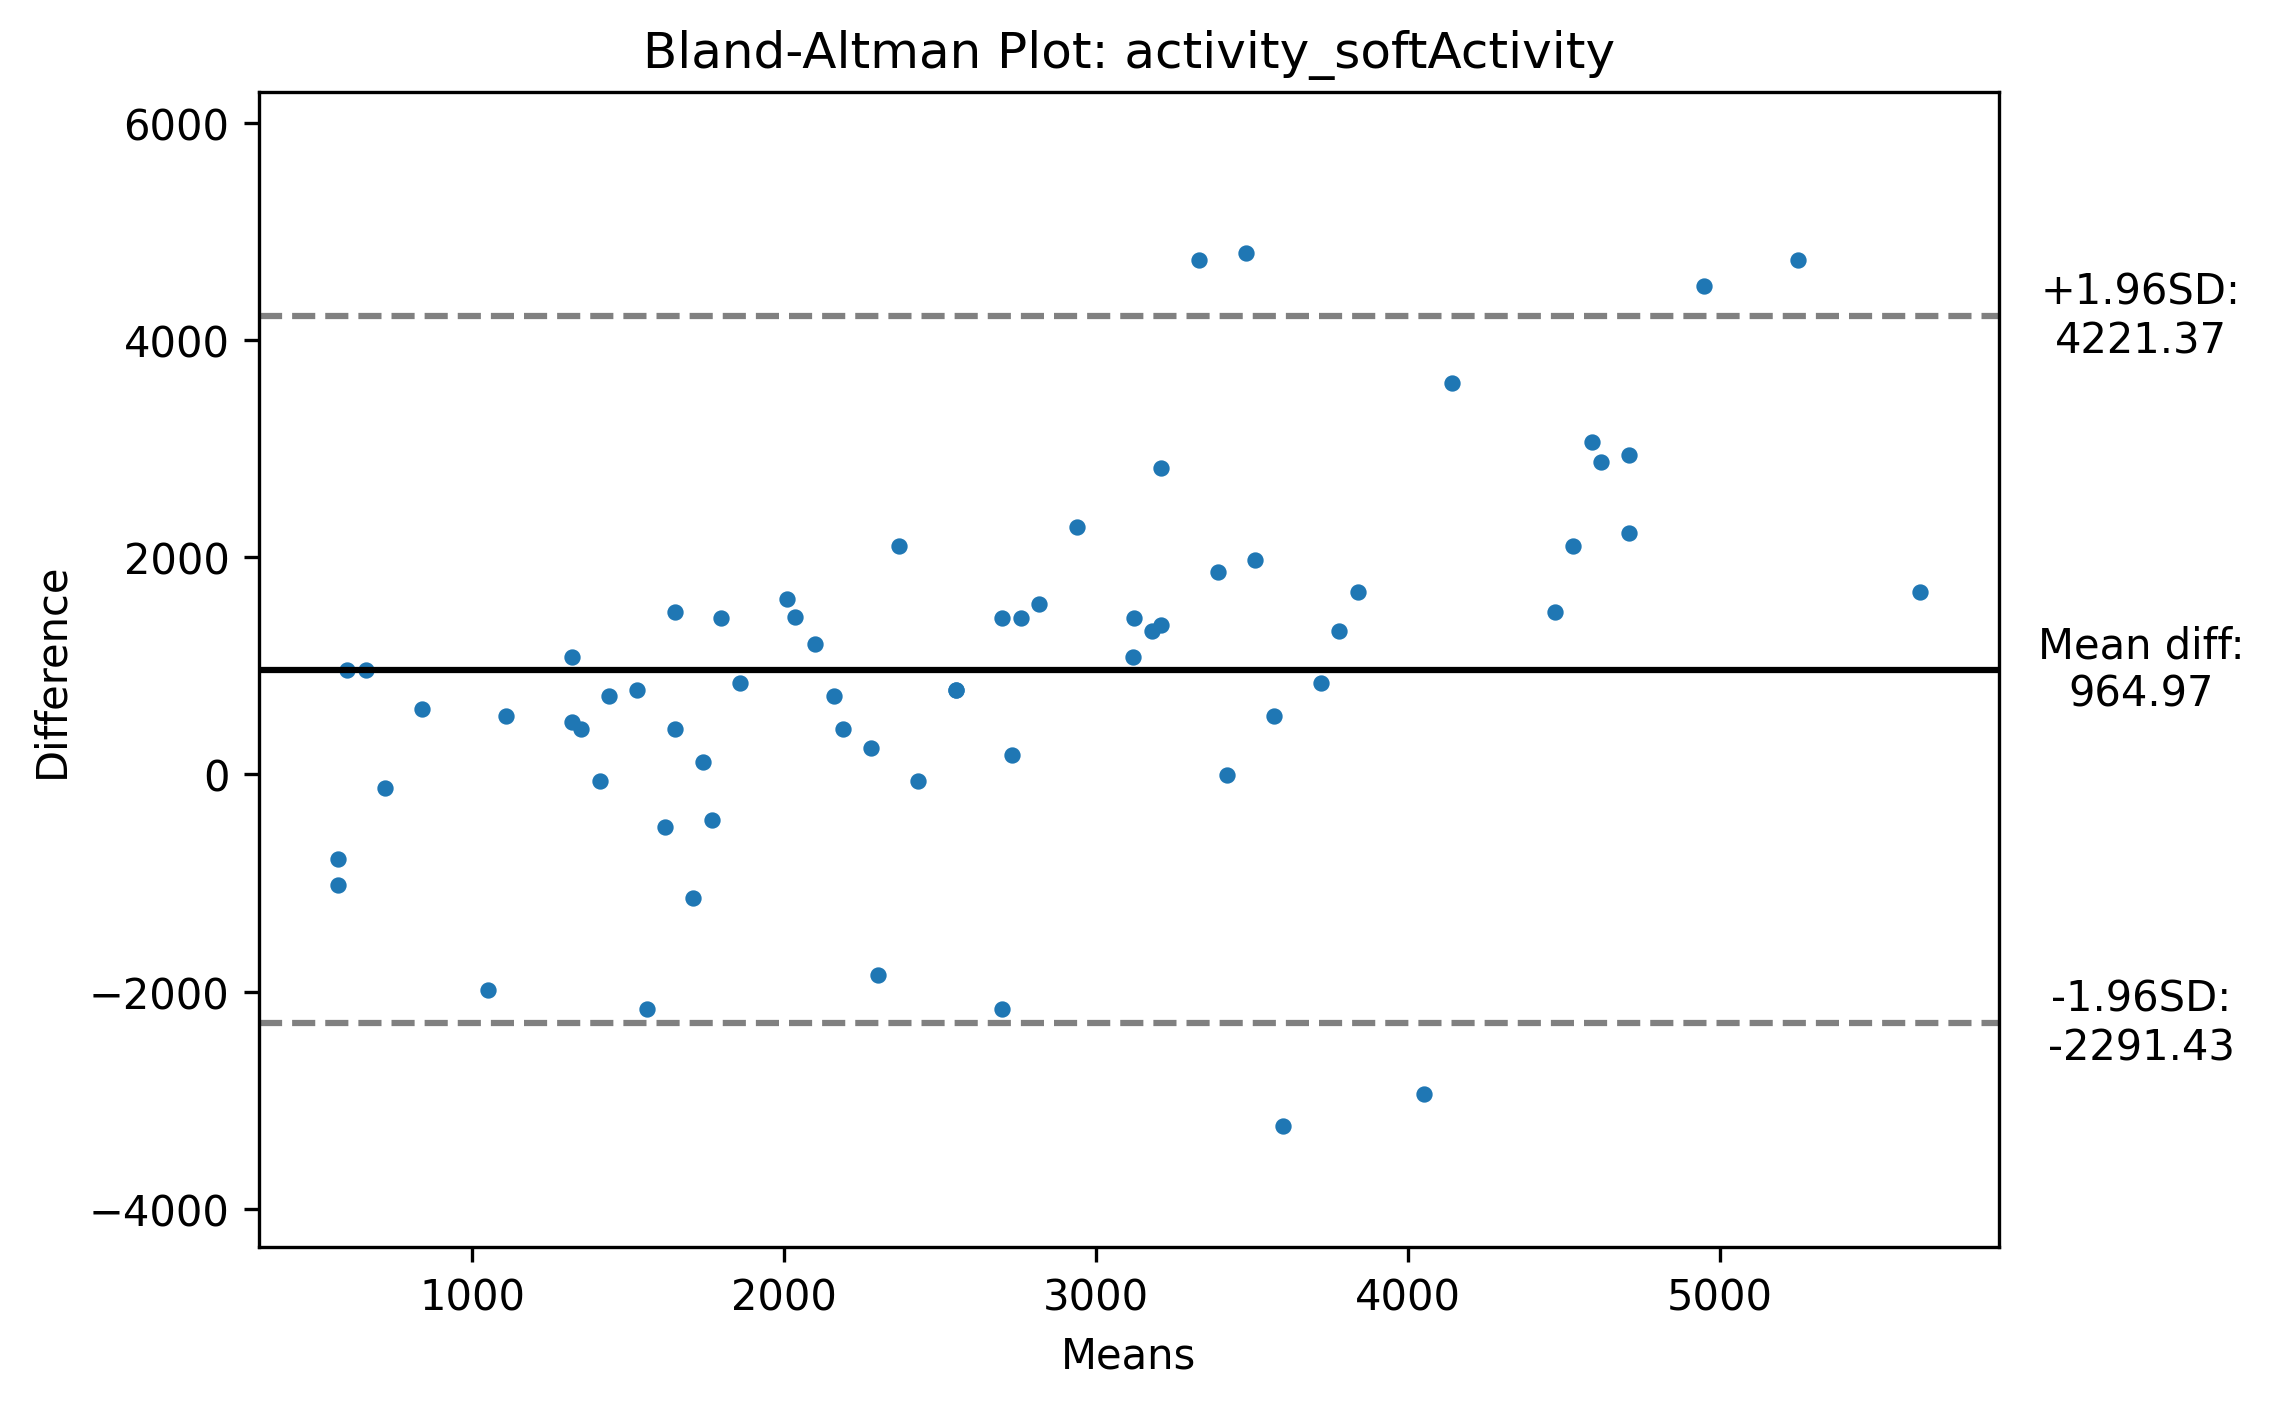

In [136]:

a = df_oura[property].values
b = df_withings[property].values
print(df_withings[property].values)
f, ax = plt.subplots(1, figsize = (8, 5))
plt.title(f"Bland-Altman Plot: {type}_{property}")
# sm.graphics.mean_diff_plot(a, b, ax=ax)
bland_altman_plot(a, b)
plt.show()

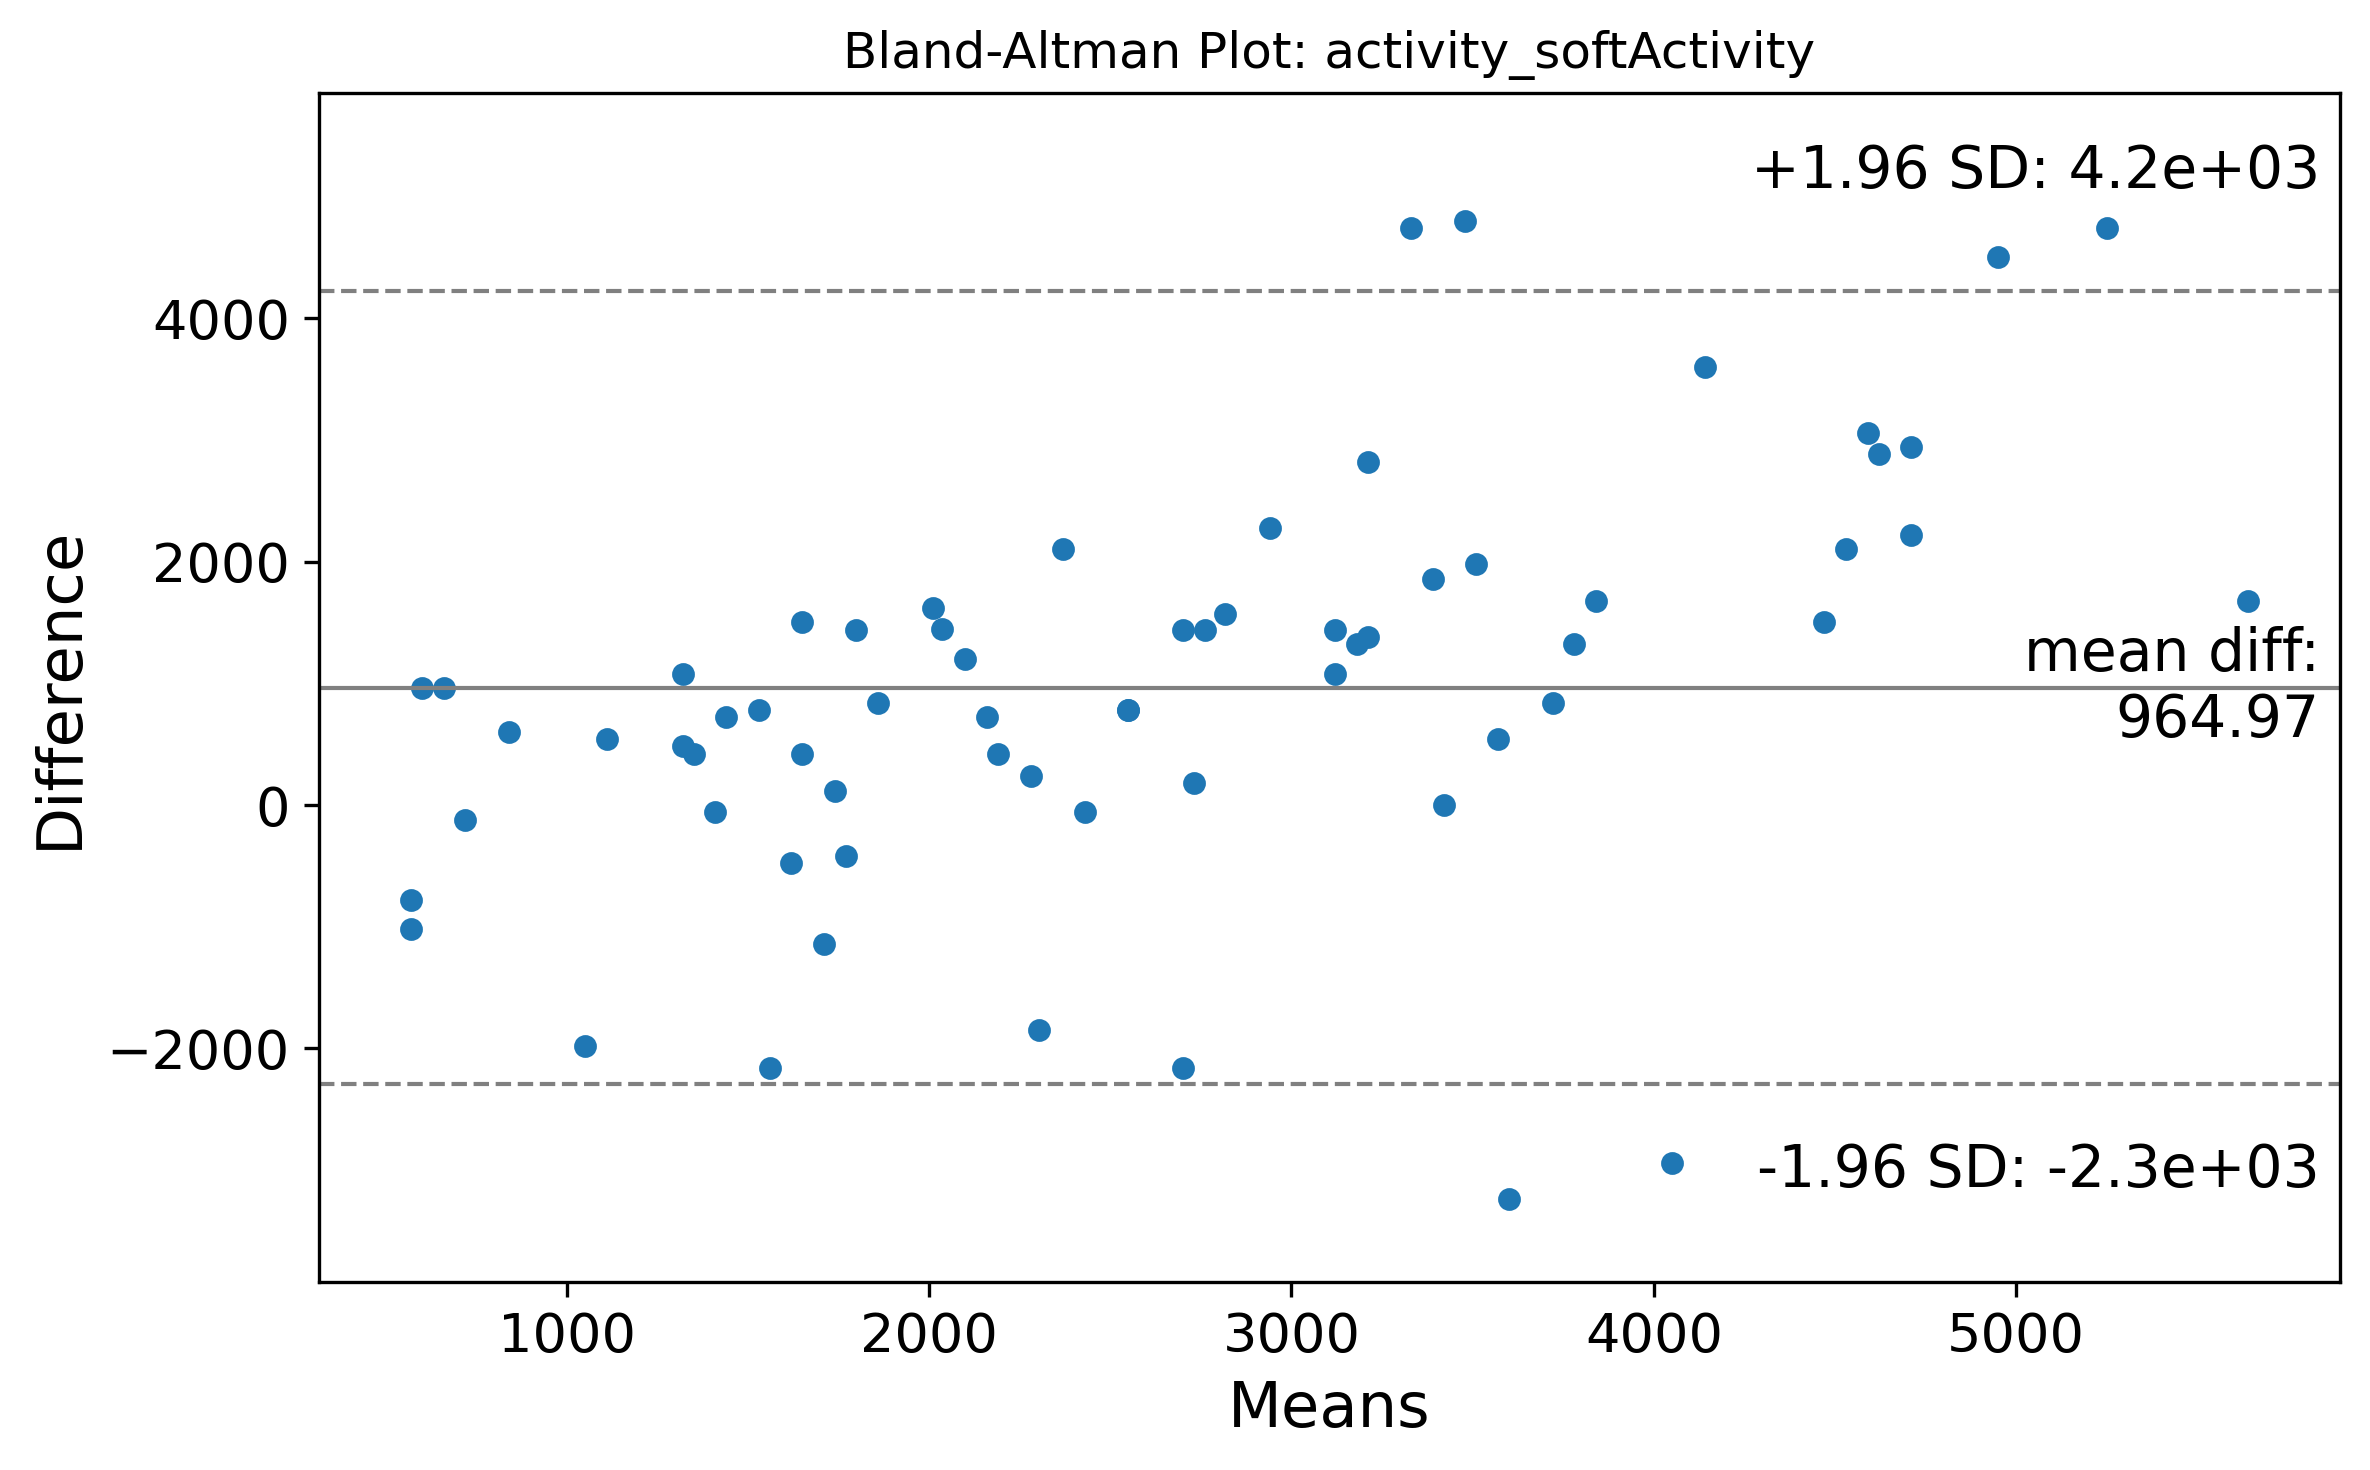

In [137]:
f, ax = plt.subplots(1, figsize = (8, 5))
plt.title(f"Bland-Altman Plot: {type}_{property}")
sm.graphics.mean_diff_plot(a, b, ax=ax)
plt.show()

sleepScore: 7.262238548274647e-17
sleepScore: 1.0399999999999998, 23.121428571428567
lightSleepDuration: 1.7224464294141753e-10
lightSleepDuration: 1.0599999999999994, 2877.3151724137915
sleepLatency: 3.26987516743905e-07
sleepLatency: 0.9950000000000008, 370.7684210526319
sleepEfficiency: 2.591717072733447e-20
sleepEfficiency: 1.1099999999999983, 7.214999999999989
totalSleepDuration: 0.014733396907999739
totalSleepDuration: 0.8950000000000007, 27.551960784313746
averageHR: 2.2098199731855853e-10
averageHR: 1.0849999999999989, 2.4325930851063804
intenseActivity: 0.003173748838439193
intenseActivity: 1.214999999999996, 765.5078571428546
caloriesBurned: 0.020119303714832223
caloriesBurned: 0.7050000000000005, 117.20312156250009
steps: 0.6204135215590747
steps: 0.42500000000000027, 353.01309523809545
moderateActivity: 1.0079120885235395e-05
moderateActivity: 1.124999999999998, 867.5507812499984
softActivity: 2.388894919884111e-06
softActivity: 0.9100000000000007, 1361.6820000000012


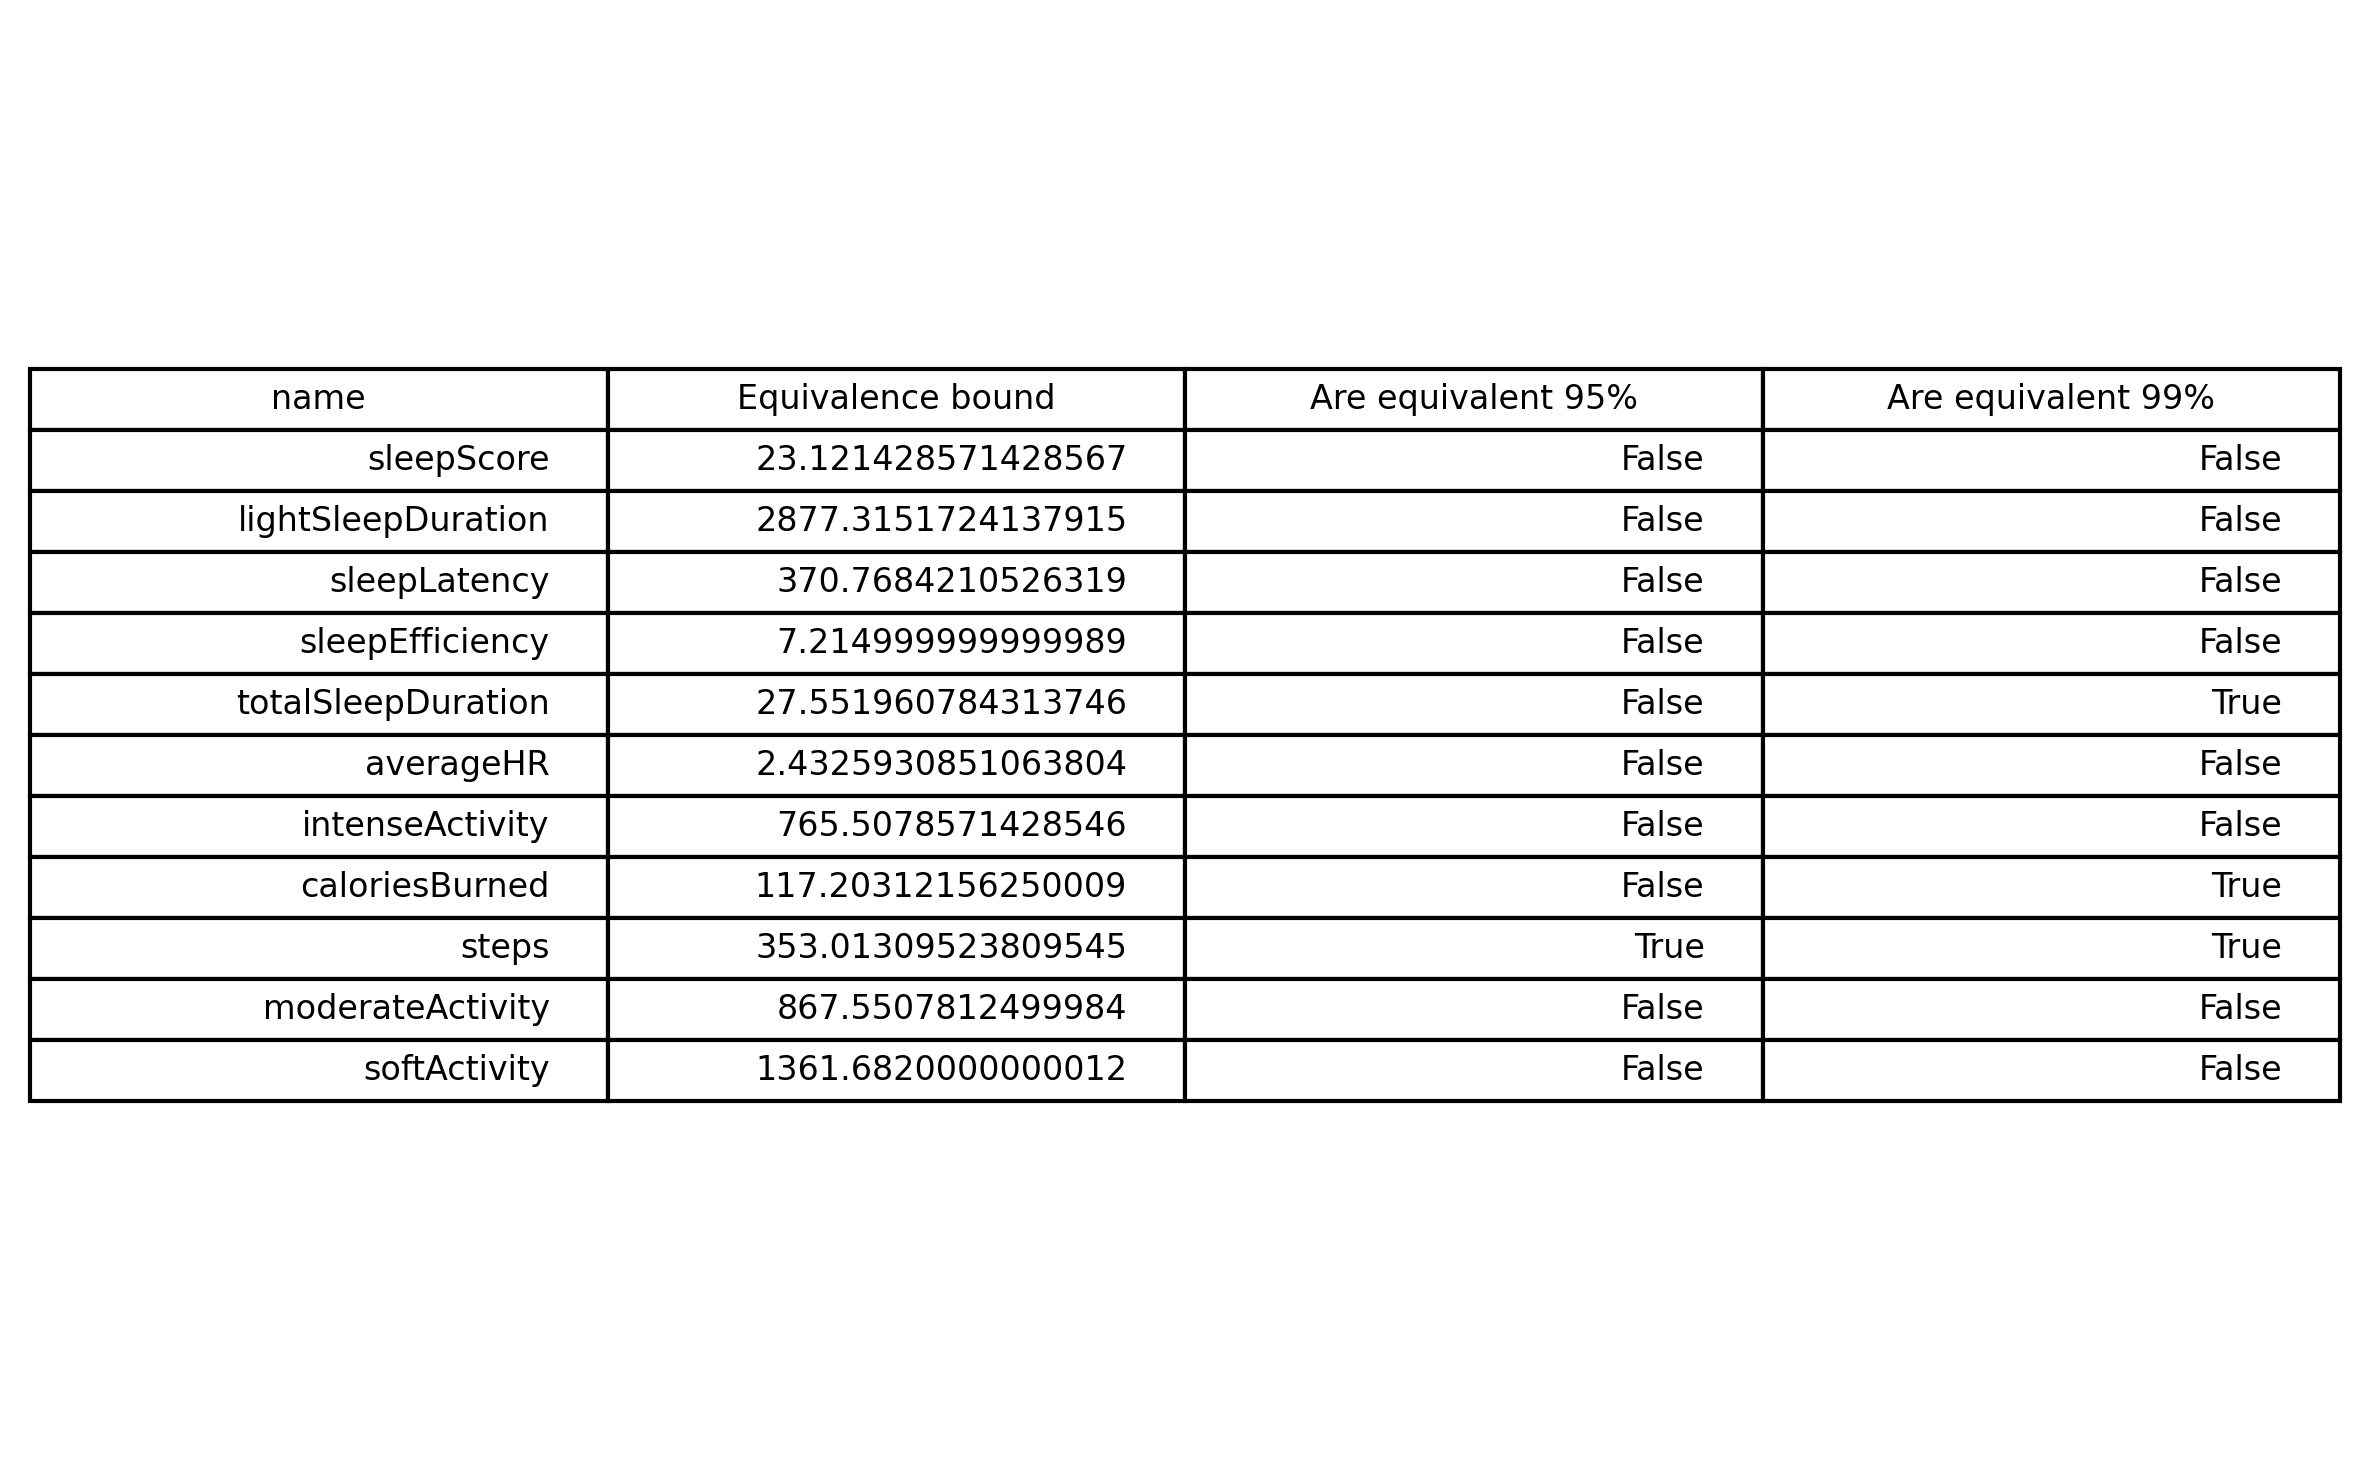

In [138]:
confidence = 0.05
increment = 0.005
margin = 0
table_df = []
zscoreOutlier = 2.5
for p in categoriesSleep:
    
    df_oura = df.loc[df["Type"] == f"sleep_Oura"]
    df_withings = df.loc[df["Type"] == f"sleep_Withings"]
    df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
    df_oura = df_oura[df_oura[p].notna()]
    df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
    df_withings = df_withings[df_withings[p].notna()]
    df_oura.set_index('date', inplace=True)
    df_withings.set_index('date', inplace=True)

    zscores = np.abs(zscore(resultSleep[resultSleep[p].notna()][p]))
    df_oura["zscores"] = zscores
    df_withings["zscores"] = zscores
    x = 0
    a = df_oura[df_oura["zscores"] <= zscoreOutlier][p].values
    b = df_withings[df_withings["zscores"] <= zscoreOutlier][p].values
    p_two = stats.ttest_rel(a, b).pvalue
    is_in = p_two <= confidence
    is_in95 = p_two <= 0.05
    is_in99 = p_two <= 0.01
    print(f"{p}: {p_two}")
    while True:
        
        margin = np.mean(np.abs(a - b)) * x
        p_val = tests.ttost_paired(a, b, -margin, margin)[0]
        
        if p_val >= confidence:
            x += increment
            continue
        print(f"{p}: {x}, {margin}")
        table_df.append([p, margin, not is_in95, not is_in99])
        break

for p in categoriesActivity:
    df_oura = df.loc[df["Type"] == f"activity_Oura"]
    df_withings = df.loc[df["Type"] == f"activity_Withings"]
    df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
    df_oura = df_oura[df_oura[p].notna()]
    df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
    df_withings = df_withings[df_withings[p].notna()]
    df_oura.set_index('date', inplace=True)
    df_withings.set_index('date', inplace=True)

    x = 0
    zscores = np.abs(zscore(resultActivity[p]))
    df_oura["zscores"] = zscores
    df_withings["zscores"] = zscores
    a = df_oura[df_oura["zscores"] <= zscoreOutlier][p].values
    b = df_withings[df_withings["zscores"] <= zscoreOutlier][p].values
    p_two = stats.ttest_rel(a, b).pvalue
    is_in95 = p_two <= 0.05
    is_in99 = p_two <= 0.01
    print(f"{p}: {p_two}")
    while True:
        
        margin = np.mean(np.abs(a - b)) * x
        p_val = tests.ttost_paired(a, b, -margin, margin)[0]
        if p_val >= confidence:
            x += increment
            continue
        print(f"{p}: {x}, {margin}")
        table_df.append([p, margin, not is_in95, not is_in99])
        break
table_df = pd.DataFrame(table_df)
table_df.head()
fig, ax = plt.subplots(figsize = (8, 5))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=table_df.values, colLabels=["name", "Equivalence bound", "Are equivalent 95%", "Are equivalent 99%"], loc='center')
fig.tight_layout()

plt.show()
